In [1]:
import sys
print(sys.path)
import numpy as np
np.random.seed(0)
import torch
import pylab
from sklearn.metrics import confusion_matrix
import itertools
from debug_visualisation import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

['', '/home/yannis/catkin_ws/devel/lib/python2.7/dist-packages', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/yannis/.local/lib/python2.7/site-packages', '/home/yannis/.local/lib/python2.7/site-packages/sacred-0.7.1-py2.7.egg', '/usr/local/lib/python2.7/dist-packages', '/home/yannis/src/edward', '/usr/local/lib/python2.7/dist-packages/sacred-0.7.2-py2.7.egg', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/python2.7/dist-packages/wx-3.0-gtk2', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/yannis/.ipython']


# Main code for Concrete Dropout

In [2]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper, Concatenate


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        input_dim = np.prod(input_shape[1:])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Using Theano backend.


### Plot function to make sure stuff makes sense:

In [3]:
def plot(reps=None,train_loss=None,valid_loss=None,uncertainty=None,val_acc=None, valid_y=None,preds=None):
    
   fig = pylab.figure() 
   _, (ax1, ax2) = pylab.subplots(1, 2,figsize=(15, 5), sharex=False, sharey=False)
   #Plot loss on training and validation set    
   ax1.plot(reps, train_loss, c='r', label='Training')
   ax1.plot(reps, valid_loss, c='g', label='Validation')
   ax1.set_title('Losses')
   ax1.legend()
   #Plot student confusion matrix
   names = ['Slight-Right-Turn','Sharp-Right-Turn','Move-Forward','Slight-Left-Turn']
   cnf_matrix = confusion_matrix(np.argmax(valid_y,axis=-1), preds)  
   pylab.sca(ax2)
   plot_confusion_matrix(cnf_matrix, classes=names,normalize=False,title='Student confusion matrix')
 
   pylab.show()

# Evaluate Concrete Dropout

In [4]:
nb_epochs = [200]
nb_reps = 50
K_test = 500
batch_size = 128
Q = 2 #24
nb_features = 7
l = 1e-6
D = 4
with open('/home/yannis/Desktop/compress_bnn/data/Wall/usableData/valid_data_2sensors_1dimTarget_70pc.pt','rb') as f:
      valid = torch.load(f)
with open('/home/yannis/Desktop/compress_bnn/data/Wall/usableData/train_data_2sensors.pt','rb') as f:
      train = torch.load(f)

        
   
N = train.shape[0]
X_tr = train[:,0:2]
Y_tr = train[:,2:4]
X_v = valid[:,0:2]
Y_v = valid[:,2:4]

o = np.zeros((len(Y_tr), 4))
o[np.arange(len(Y_tr)), Y_tr.flatten().astype(int)] = 1   
Y_tr = o

o = np.zeros((len(Y_v), 4))
o[np.arange(len(Y_v)), Y_v.flatten().astype(int)] = 1   
Y_v = o

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
print(scaler.mean_)
print(scaler.var_)
X_v = scaler.transform(X_v)


 

[1.29612657 0.67692819]
[0.39477931 0.10829069]


### Fit function:

In [8]:
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras import backend as K

def fit_model(nb_epoch, X, Y, validation_data=None):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(Q,))
    x = inp
    """
    x = ConcreteDropout(Dense(nb_features, activation='relu',name='CD1'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    #x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(D,activation='sigmoid',name='CD2'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    """
    x = Dense(64, activation='relu',name='CD1')(x) 
    x = ConcreteDropout(Dense(32, activation='relu',name='CD1b'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(16, activation='relu',name='CD1d'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(8, activation='relu',name='CD1c'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = Dense(D,activation='softmax',name='CD2')(x)
    
    out = x 
    model = Model(inp, out)
    
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    #assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 3  # a loss for each Concrete Dropout layer
    if validation_data==None:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0)    
    else:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_data=validation_data)
    loss = hist.history['loss'][-1]
    return hist,model, -0.5 * loss  # return ELBO up to const.

### Eval function:

In [9]:
def test(Y_true, MC_samples):
    """
    :Y_true: a 2D array of size N x 4
    :MC_samples: a 3D array of size samples K x N x 4
    """
    assert len(MC_samples.shape) == 3
    assert len(Y_true.shape) == 2
    
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    #Get probability of each class after MC sampling, so that we can get the mean
    
    MC_means = np.sum(MC_samples,axis=0)/float(k)
    MC_pred = np.argmax(MC_means,axis=-1)   
    y_pred = np.argmax(Y_true,axis=-1)
    acc = len(np.where(MC_pred==y_pred)[0])/float(N)*100
    print("\n ( Micro Averaging ) Accuracy: {}".format(acc))

    #For variation ratio
    predictions_per_test_point = np.argmax(MC_samples,axis=-1)
    mode_fx = []
    MC_majVote = np.zeros(MC_pred.shape)
    for i in xrange(N):
        values,votes = np.unique(predictions_per_test_point[:,i], return_counts=True)
        m = np.argmax(votes)
        mode_fx.append((values[m],votes[m]))
        MC_majVote[i] = values[m]
    acc2 = len(np.where(MC_majVote==y_pred)[0])/float(N)*100
    print("\n ( Macro Averaging ) Accuracy: {}".format(acc2))
    
    
        
    return acc, acc2, MC_means, MC_pred, mode_fx

        

#Run experiment


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.4757536042
0.0053709043250327665
0.027398758134554443
nan
[143 214 287 461]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

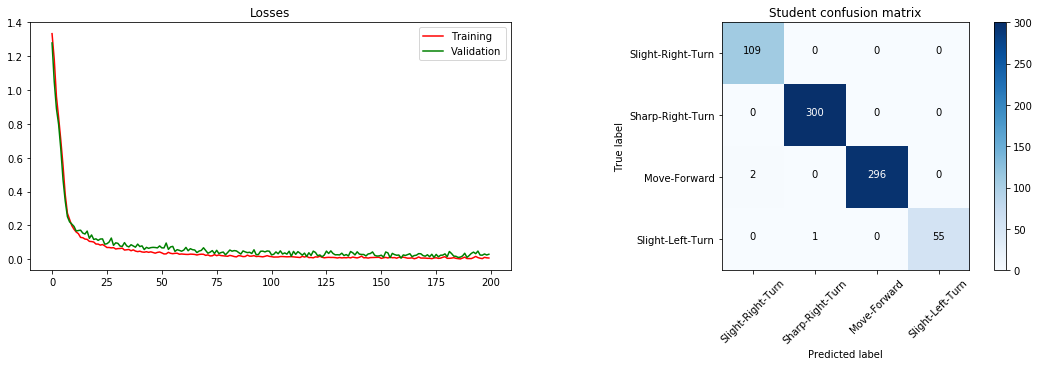


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.006532110091743119
0.028254557718299475
nan
[143 214 287]
Confusion matrix, without normalization
[[107   0   2   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

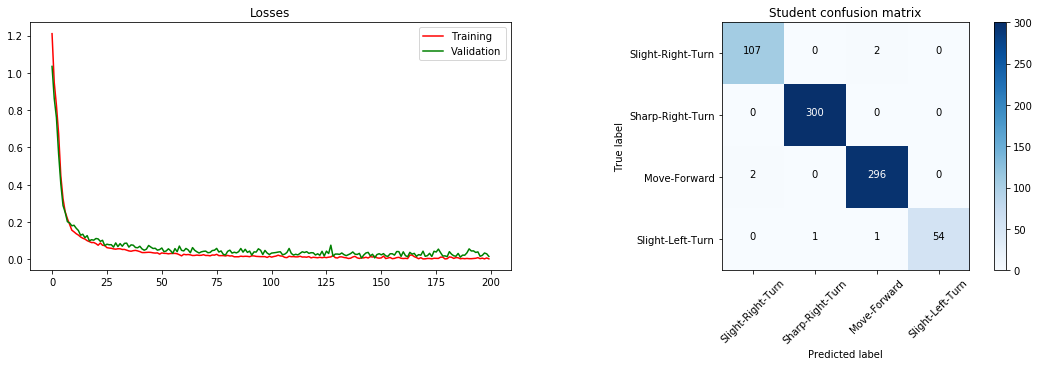


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.005861074705111403
0.031549041268084964
0.00661864224455147
[]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

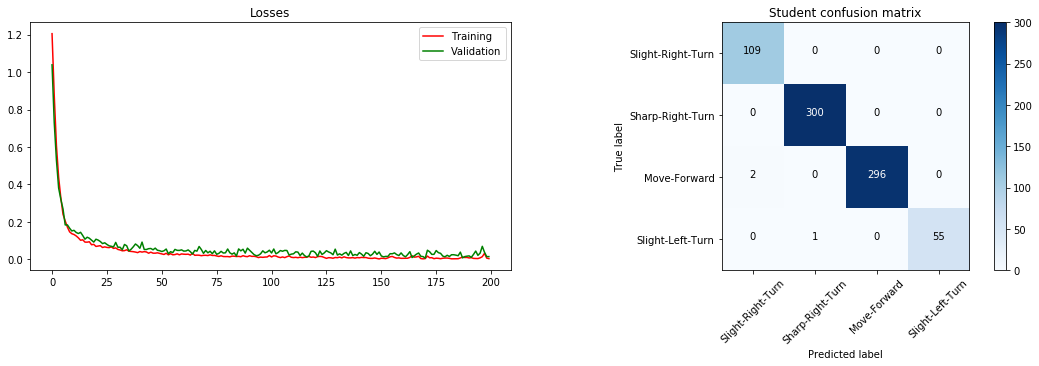


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.004463958060288336
0.024627540558381286
nan
[143 214 287 461 733]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  3   0 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

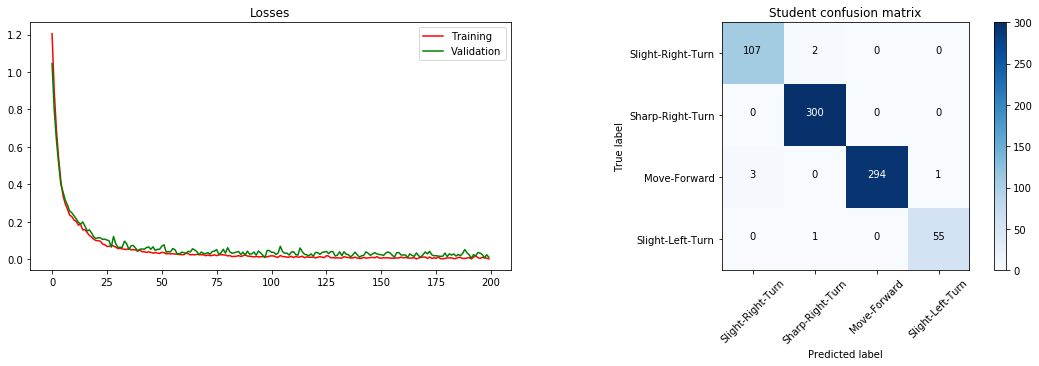


 ( Micro Averaging ) Accuracy: 98.6893840105

 ( Macro Averaging ) Accuracy: 98.6893840105
0.004592398427260813
0.02777575321622476
0.0063549056746856555
[]
Confusion matrix, without normalization
[[105   2   2   0]
 [  0 300   0   0]
 [  2   1 295   0]
 [  0   1   2  53]]


<Figure size 432x288 with 0 Axes>

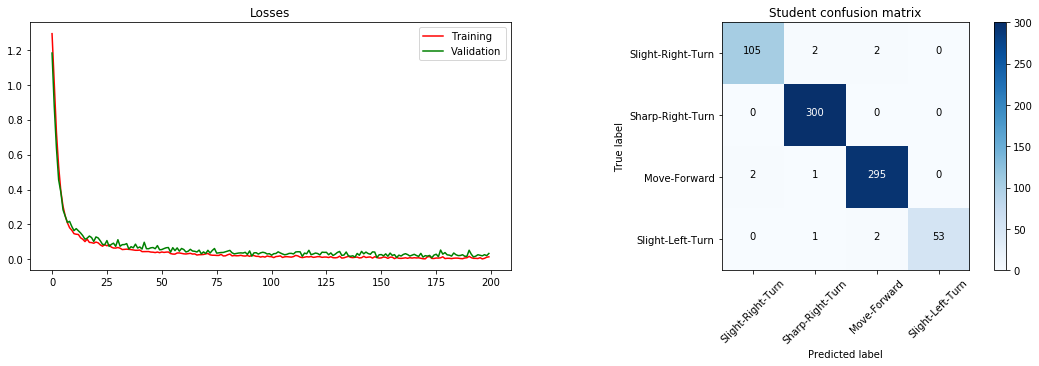


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.0056356487549148095
0.02635091879108474
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   1   2  53]]


<Figure size 432x288 with 0 Axes>

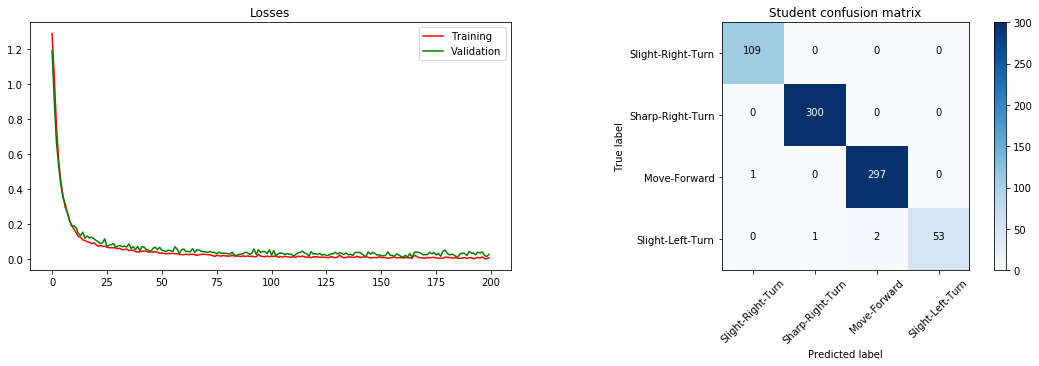


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.004311926605504587
0.02517624951283866
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

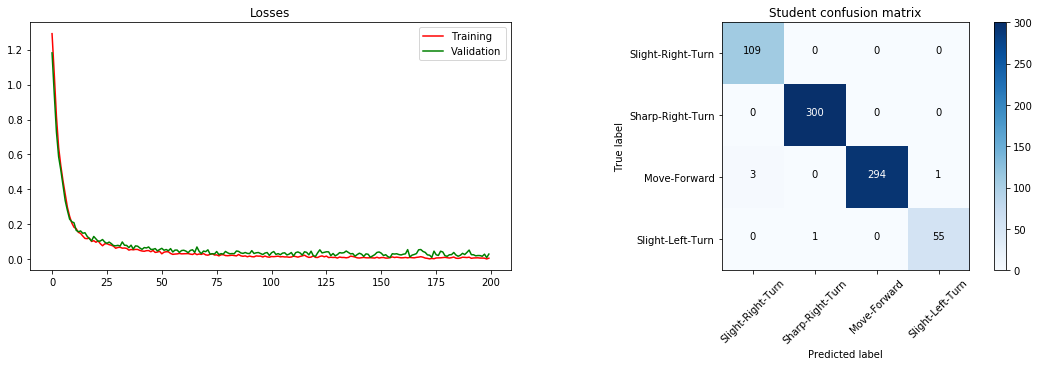


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.4757536042
0.005913499344692006
0.026585400182641505
nan
[143 214 287]
Confusion matrix, without normalization
[[108   0   1   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

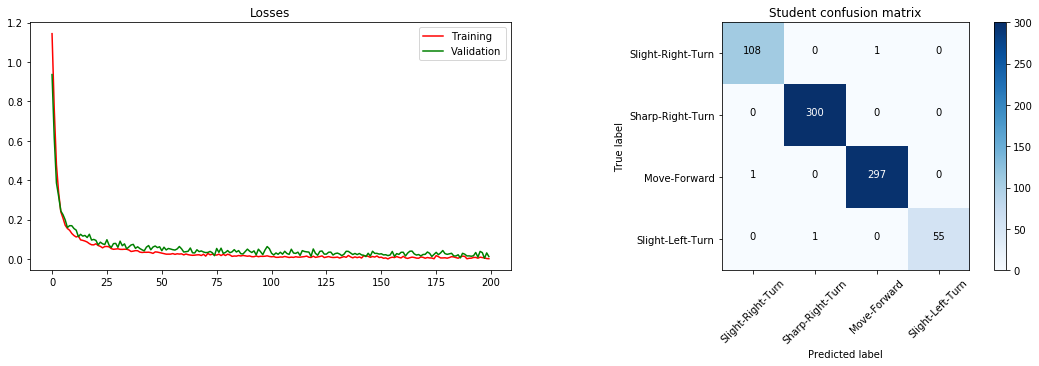


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.2136304063
0.0037457404980340767
0.025565176147620924
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  4   0 294   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

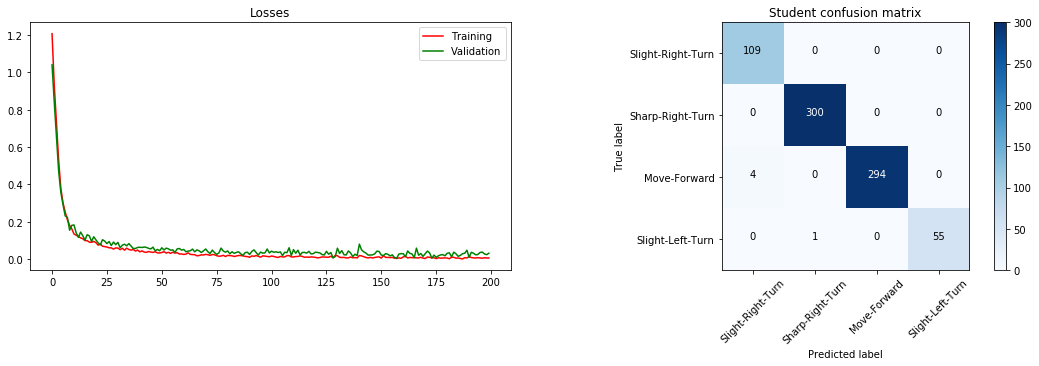


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.005331585845347314
0.025598093535297038
nan
[143 214 287 461]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

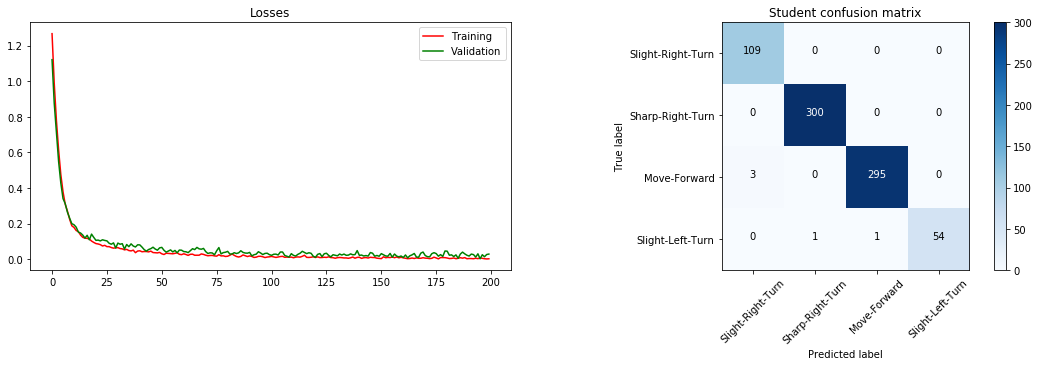


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.003682830930537353
0.026823561282176646
nan
[ 27  71 143 214 260 277 287 658 734]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

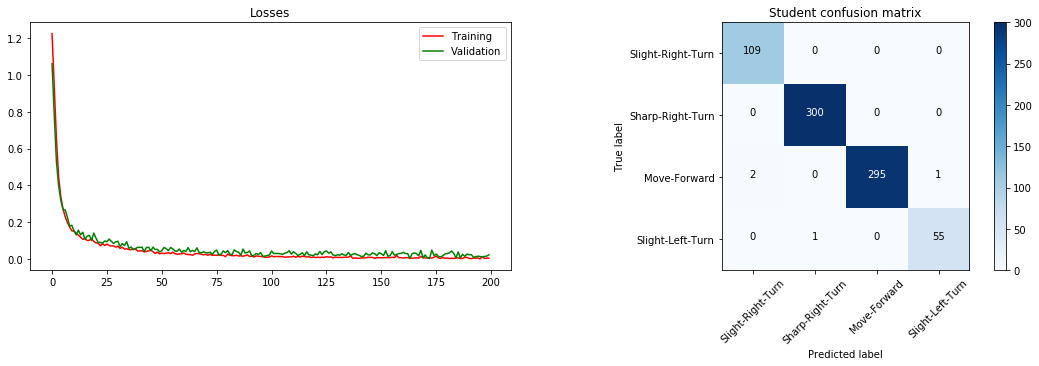


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.3446920052
0.004998689384010485
0.0306129255582277
nan
[ 91 104 143 213 214 267 271 287 359 372 452 461 463 548 588 669 681 721
 726 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  4   0 294   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

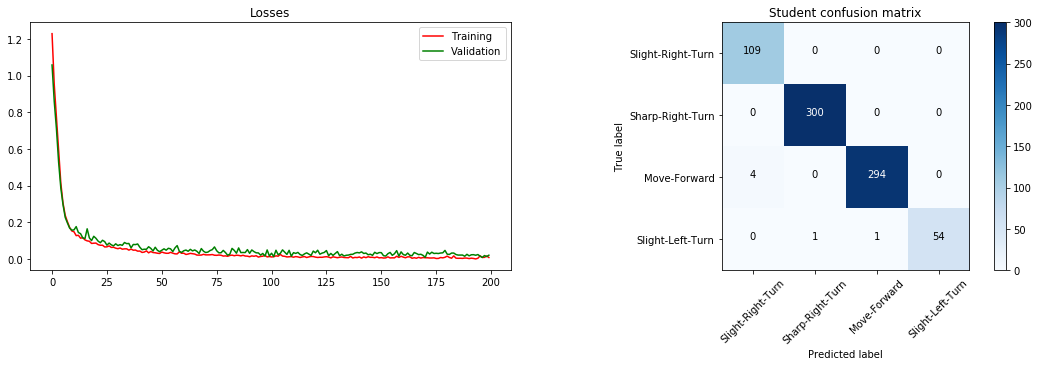


 ( Micro Averaging ) Accuracy: 98.9515072084

 ( Macro Averaging ) Accuracy: 98.9515072084
0.007315858453473133
0.031482134077839584
0.0068391247470600755
[]
Confusion matrix, without normalization
[[104   0   5   0]
 [  0 298   2   0]
 [  0   0 298   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

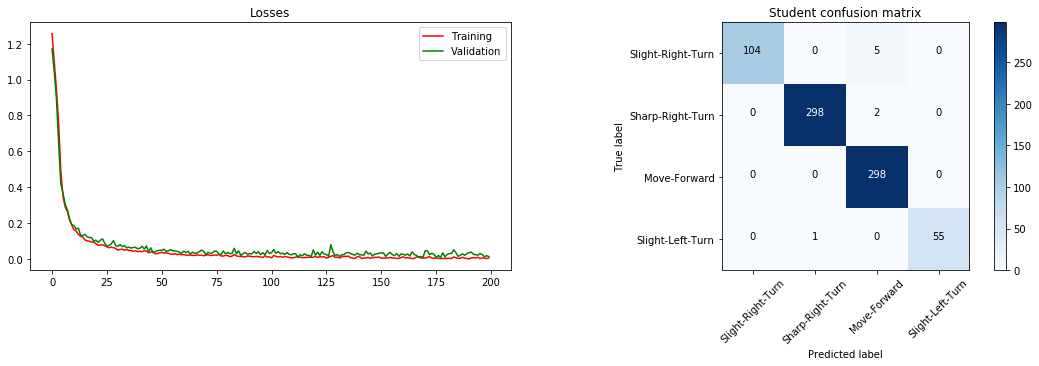


 ( Micro Averaging ) Accuracy: 98.8204456094

 ( Macro Averaging ) Accuracy: 98.9515072084
0.005279161205766711
0.027841530496139827
nan
[143 214 287]
Confusion matrix, without normalization
[[102   0   7   0]
 [  0 300   0   0]
 [  0   0 297   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

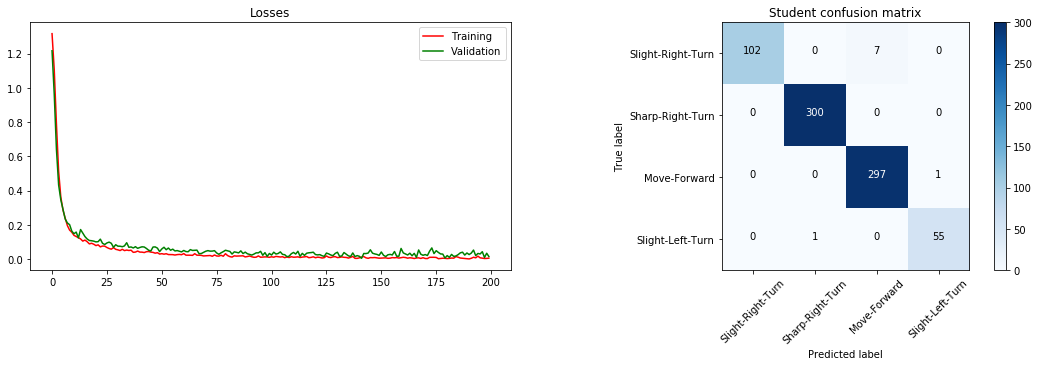


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.004560943643512451
0.02393205825185713
nan
[ 91 104 213 267 271 359 372 452 461 463 548 588 669 681 721 726 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

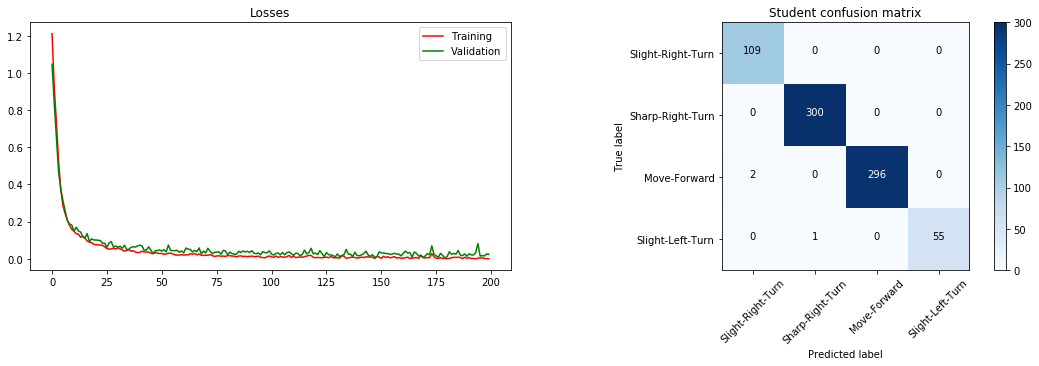


 ( Micro Averaging ) Accuracy: 98.9515072084

 ( Macro Averaging ) Accuracy: 98.9515072084
0.0040104849279161215
0.028862801948037402
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 299   1   0]
 [  5   0 292   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

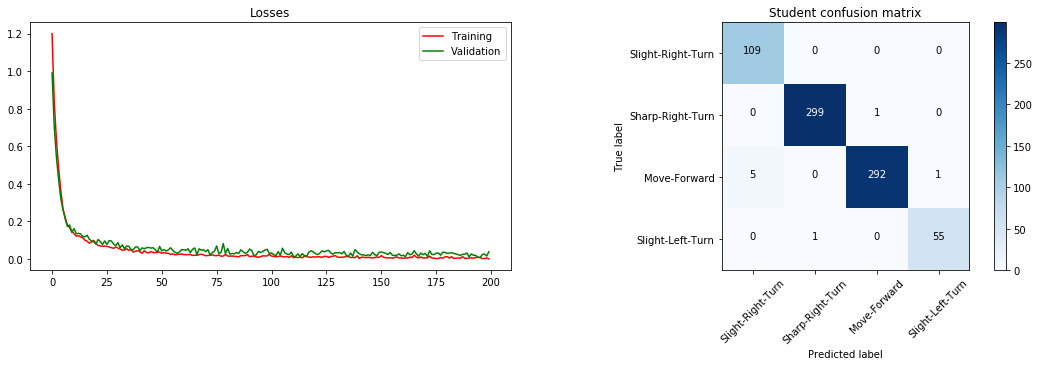


 ( Micro Averaging ) Accuracy: 98.9515072084

 ( Macro Averaging ) Accuracy: 98.9515072084
0.005695937090432503
0.027875877770340146
nan
[143]
Confusion matrix, without normalization
[[103   0   6   0]
 [  0 300   0   0]
 [  0   0 298   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

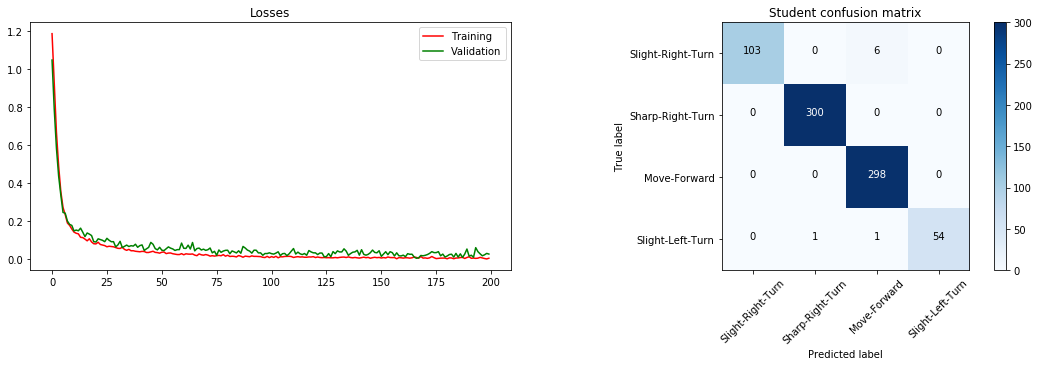


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.3446920052
0.005879423328964614
0.02700740419240329
nan
[143 214 287]
Confusion matrix, without normalization
[[107   0   2   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

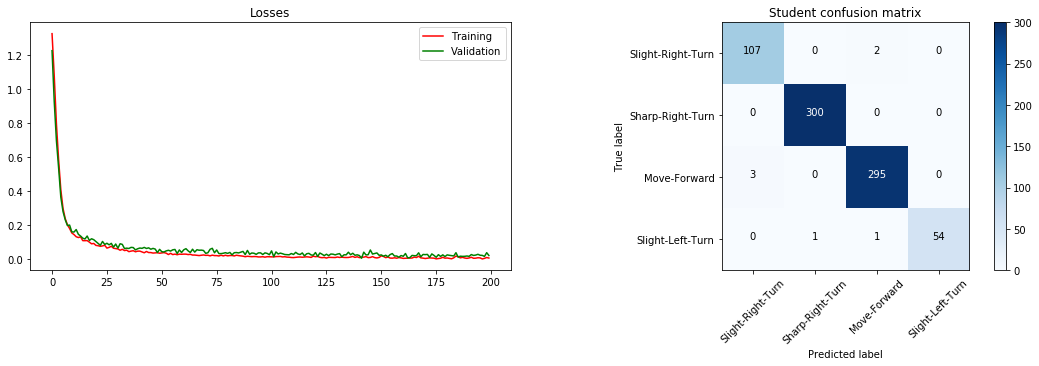


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.004511140235910878
0.025602118215898386
nan
[143]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

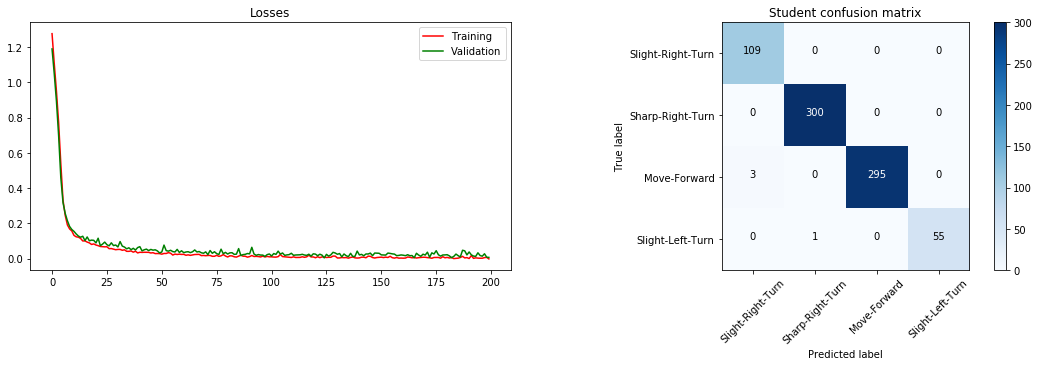


 ( Micro Averaging ) Accuracy: 98.9515072084

 ( Macro Averaging ) Accuracy: 98.8204456094
0.007971166448230668
0.028798009589958942
nan
[143 214 287]
Confusion matrix, without normalization
[[106   0   3   0]
 [  0 299   1   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

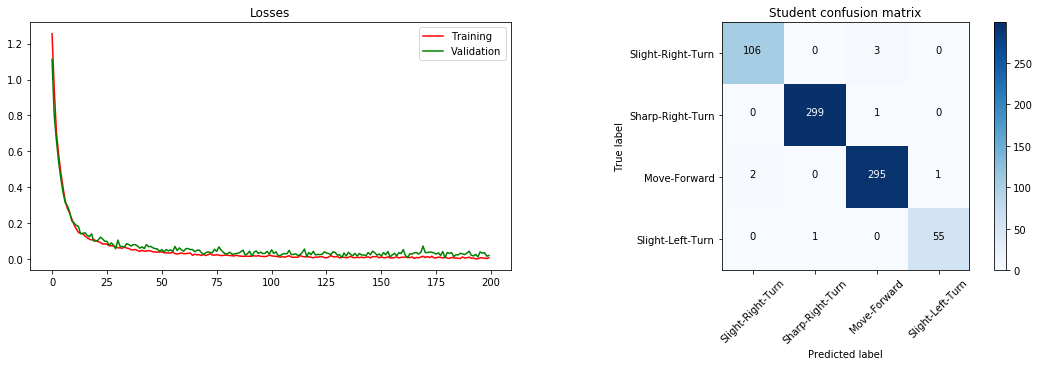


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.3446920052
0.006901703800786371
0.030536306638705154
nan
[143 214 287]
Confusion matrix, without normalization
[[107   0   2   0]
 [  0 299   1   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

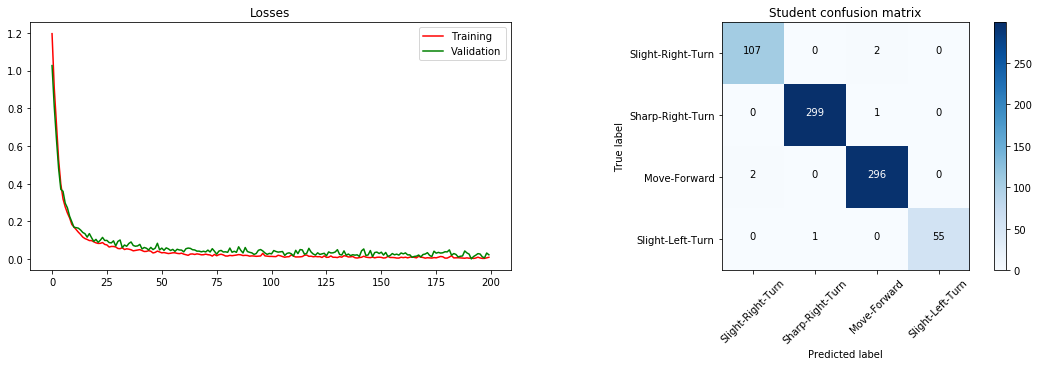


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.006382699868938401
0.0267991332207876
nan
[143 214 287]
Confusion matrix, without normalization
[[105   0   4   0]
 [  0 300   0   0]
 [  1   0 296   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

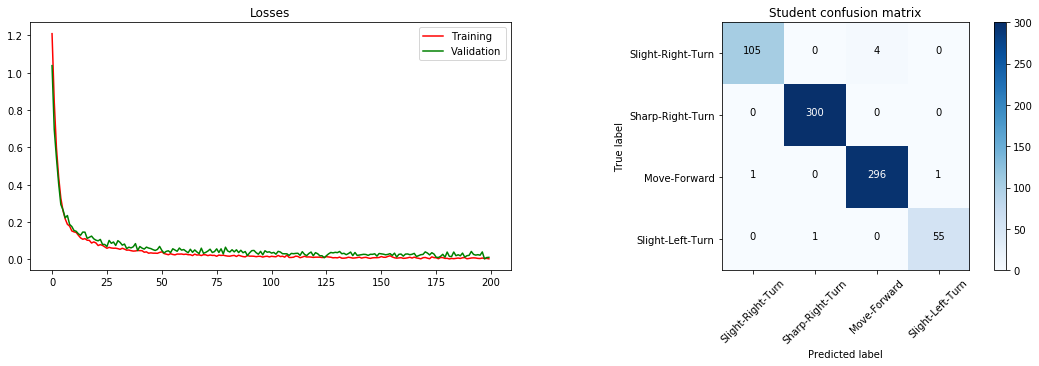


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.0825688073
0.007834862385321101
0.03255684628867853
nan
[143 214 287]
Confusion matrix, without normalization
[[107   0   2   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

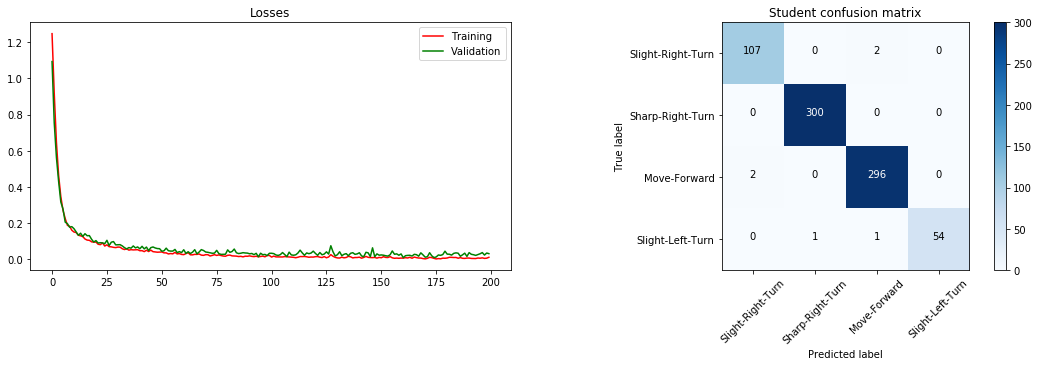


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.006225425950196592
0.03141283457744793
nan
[143]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 297   3   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

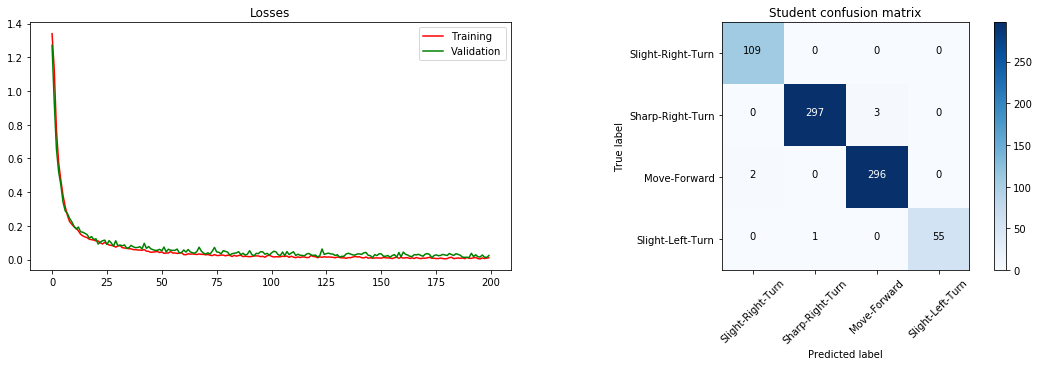


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.3446920052
0.006786369593709044
0.02895718695764304
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 299   1   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

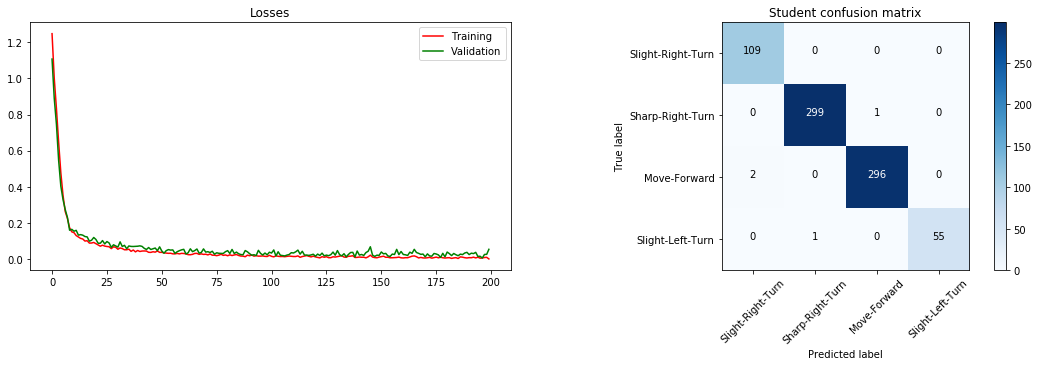


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.004251638269986894
0.027079765949774227
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

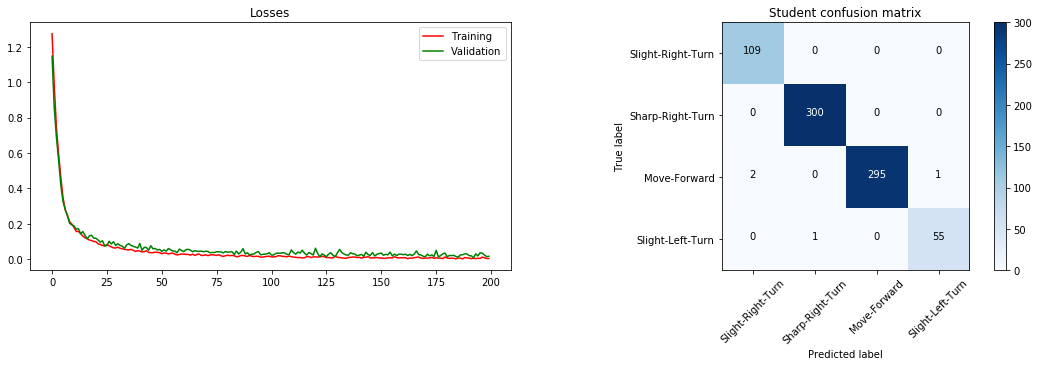


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.006230668414154653
0.028081331465534896
nan
[143 214 287]
Confusion matrix, without normalization
[[106   0   3   0]
 [  0 300   0   0]
 [  0   0 298   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

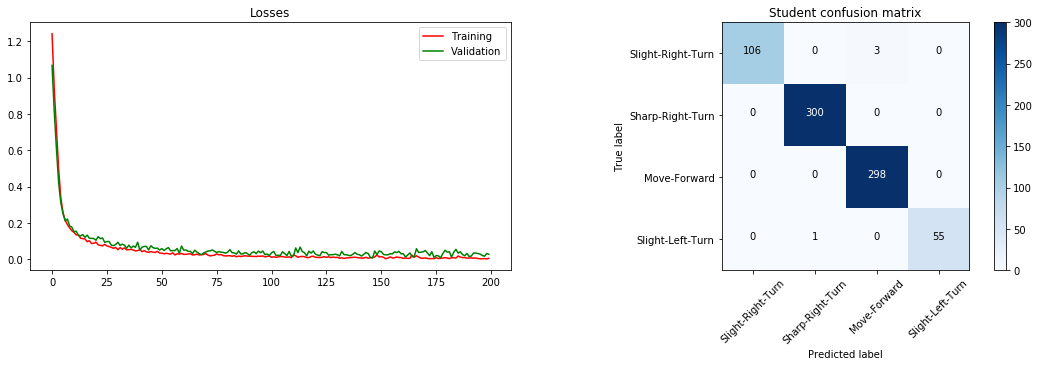


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.005066841415465269
0.02481334081327306
nan
[143 214 287]
Confusion matrix, without normalization
[[106   0   3   0]
 [  0 300   0   0]
 [  1   0 296   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

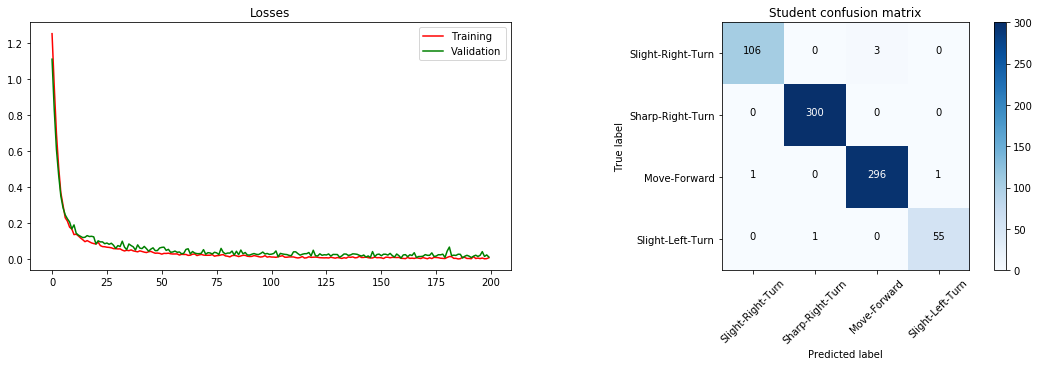


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.0037221494102228046
0.024320919891797386
nan
[143 461 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

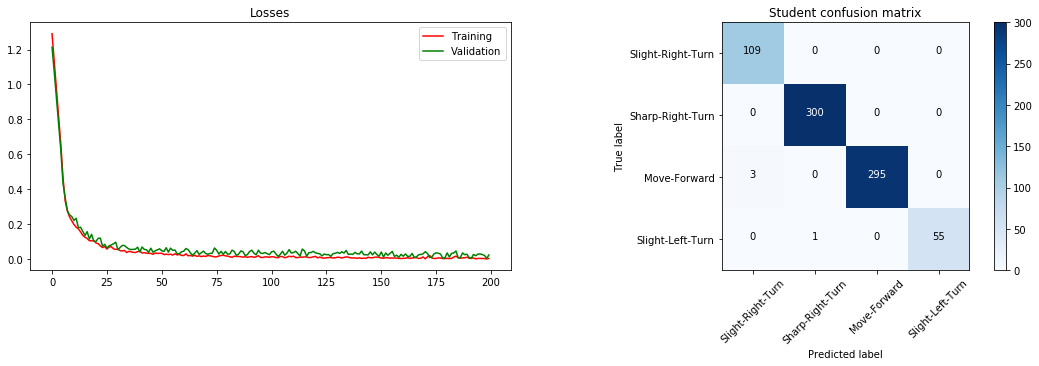


 ( Micro Averaging ) Accuracy: 98.9515072084

 ( Macro Averaging ) Accuracy: 99.2136304063
0.006390563564875493
0.027062527317832055
nan
[143 214 287]
Confusion matrix, without normalization
[[103   0   6   0]
 [  0 300   0   0]
 [  0   0 298   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

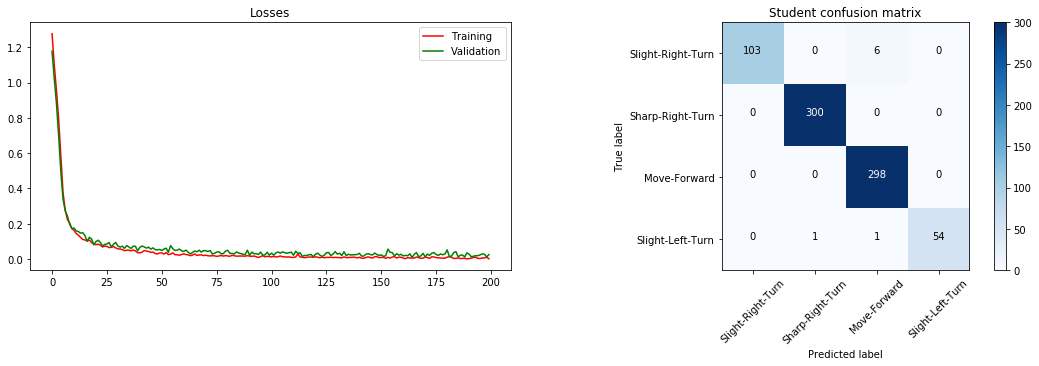


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.0029410222804718226
0.02633236526349269
nan
[143 461]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

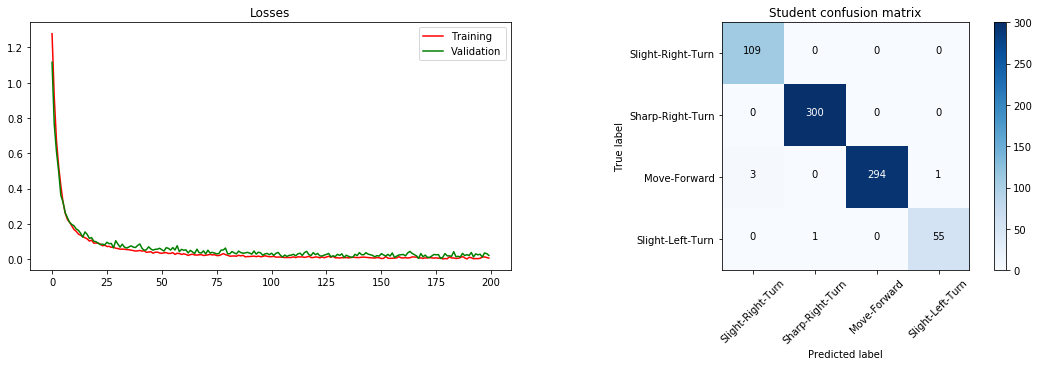


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.006073394495412845
nan
nan

 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.006018348623853212
0.03081854174052747
nan
[143]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 299   1   0]
 [  2   0 296   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

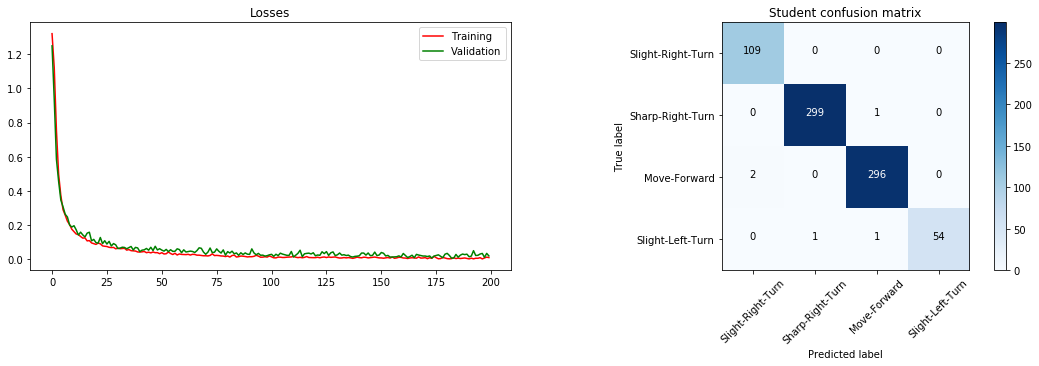


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.2136304063
0.005908256880733944
0.02797126270059208
nan
[143 214 287]
Confusion matrix, without normalization
[[106   0   3   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

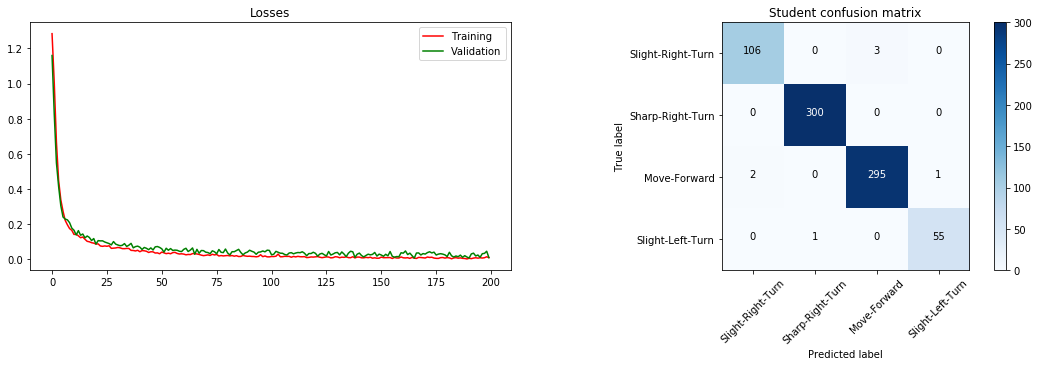


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.0072870249017038015
0.02877165168172254
nan
[143 214 287 461 658 734]
Confusion matrix, without normalization
[[104   0   5   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

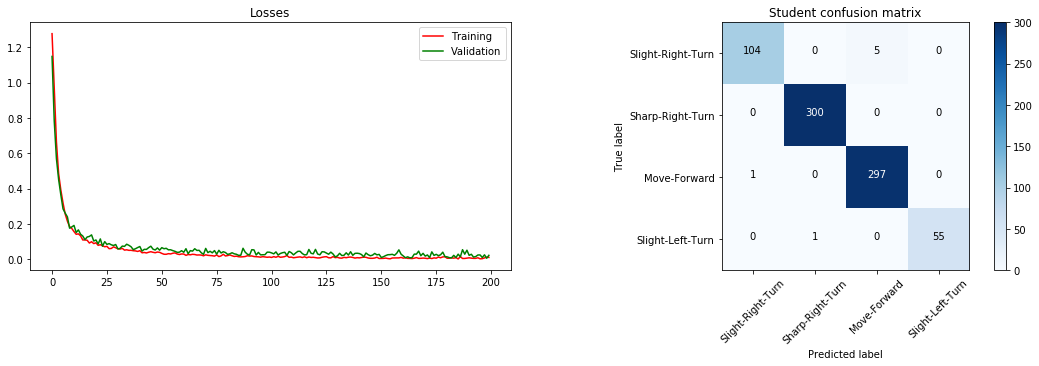


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.0057195281782437745
0.02460856206451456
nan
[143 214 267 287 461]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  1   2 295   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

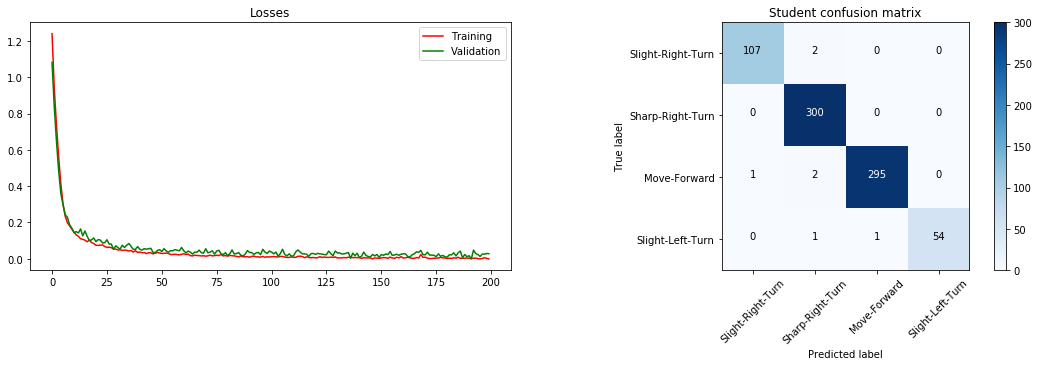


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.007019659239842727
0.030418385996887287
0.006823191011561324
[]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 299   1   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

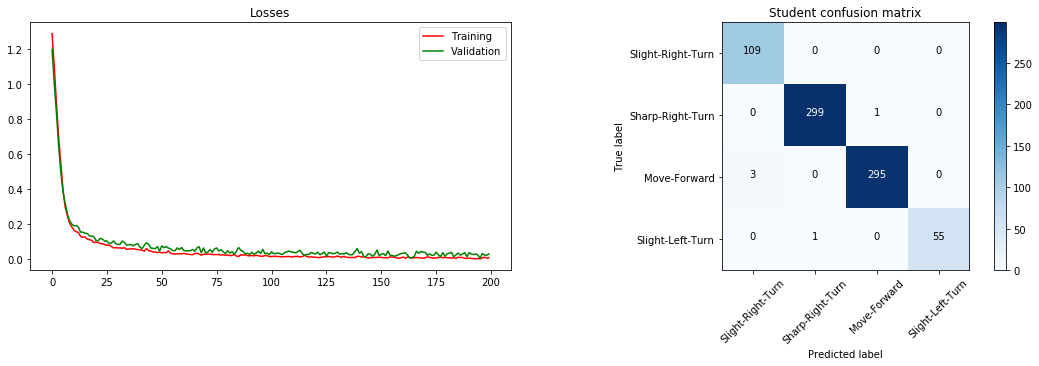


 ( Micro Averaging ) Accuracy: 98.8204456094

 ( Macro Averaging ) Accuracy: 98.8204456094
0.004078636959370905
nan
nan

 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.4757536042
0.006550458715596329
0.02727967258518364
nan
[143 214 287]
Confusion matrix, without normalization
[[107   0   2   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

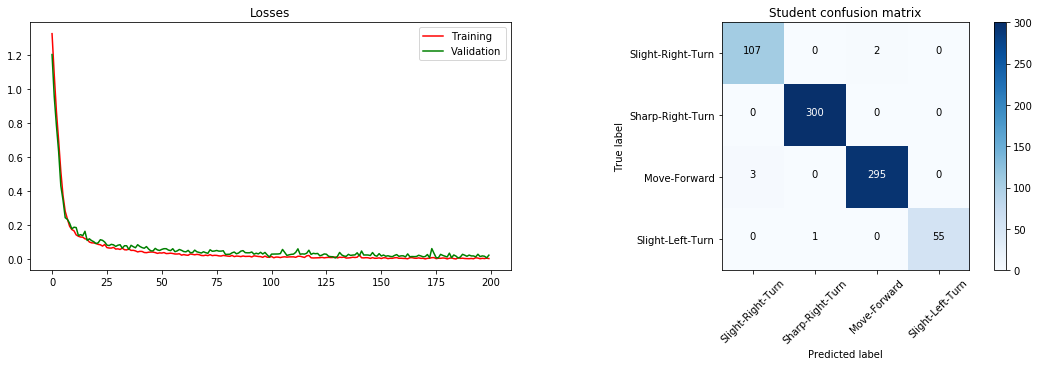


 ( Micro Averaging ) Accuracy: 98.8204456094

 ( Macro Averaging ) Accuracy: 98.9515072084
0.007310615989515073
0.030204157998021276
nan
[143 214 287]
Confusion matrix, without normalization
[[103   0   6   0]
 [  0 299   1   0]
 [  1   0 297   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

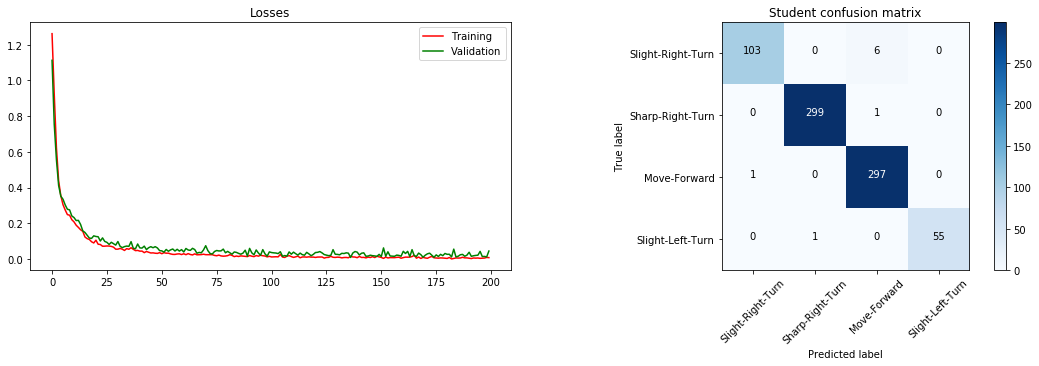


 ( Micro Averaging ) Accuracy: 99.7378768021

 ( Macro Averaging ) Accuracy: 99.6068152031
0.006201834862385321
0.028980227629135352
nan
[143]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 299   1   0]
 [  0   0 298   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

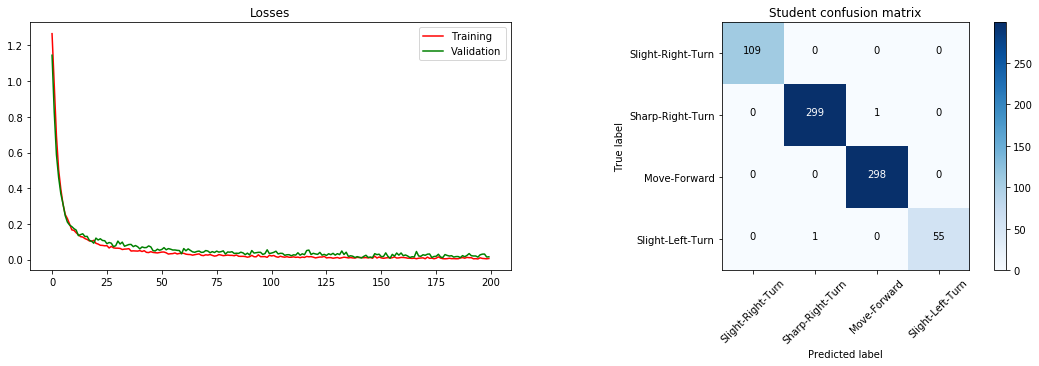


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.4757536042
0.005913499344692006
0.028316192826937255
nan
[ 27  71  72 143 178 214 287 477 519 658 734]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 299   1   0]
 [  2   0 296   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

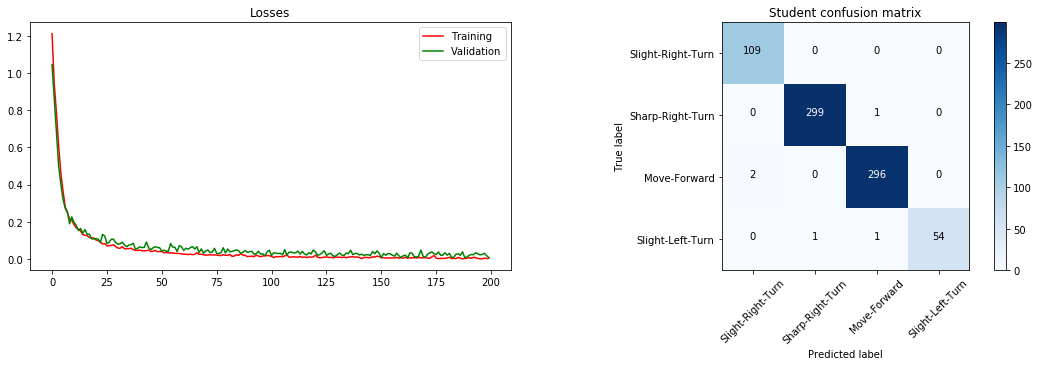


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.3446920052
0.0063381389252948886
0.02972862073665834
nan
[143 214 287 658 734]
Confusion matrix, without normalization
[[106   0   3   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

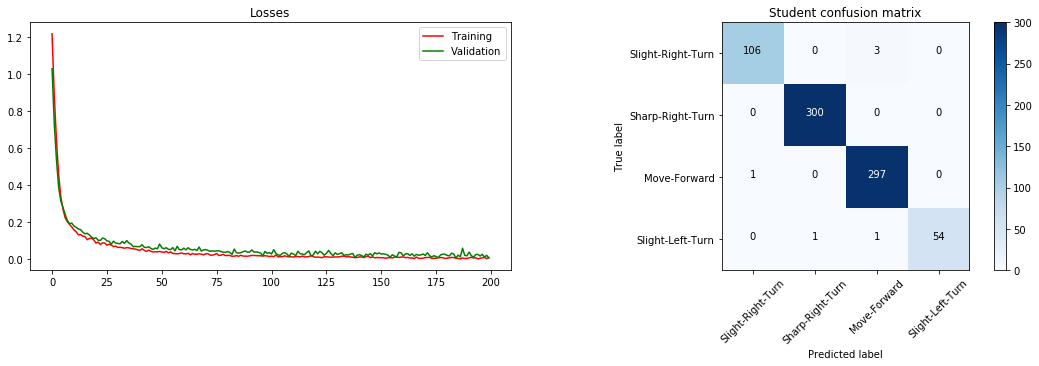


 ( Micro Averaging ) Accuracy: 98.8204456094

 ( Macro Averaging ) Accuracy: 98.9515072084
0.008825688073394495
0.037248928925000514
nan
[143 214 287]
Confusion matrix, without normalization
[[103   0   6   0]
 [  0 298   2   0]
 [  0   0 298   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

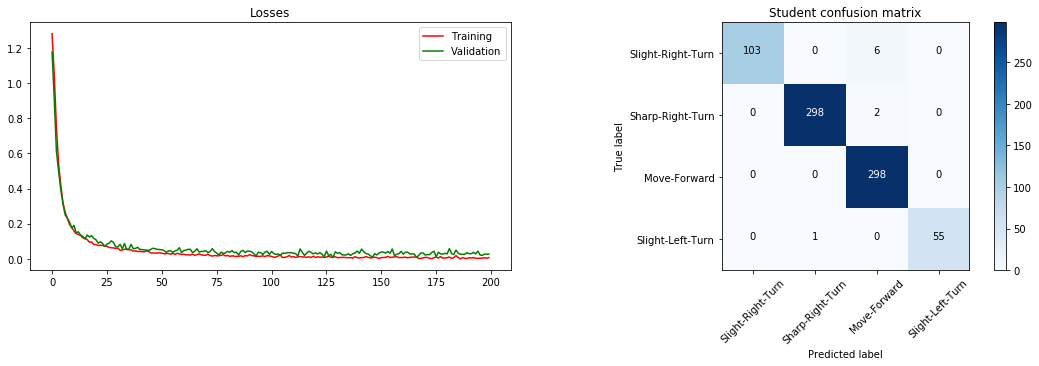


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.004450851900393185
0.024804936480240927
0.005021547739971353
[]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

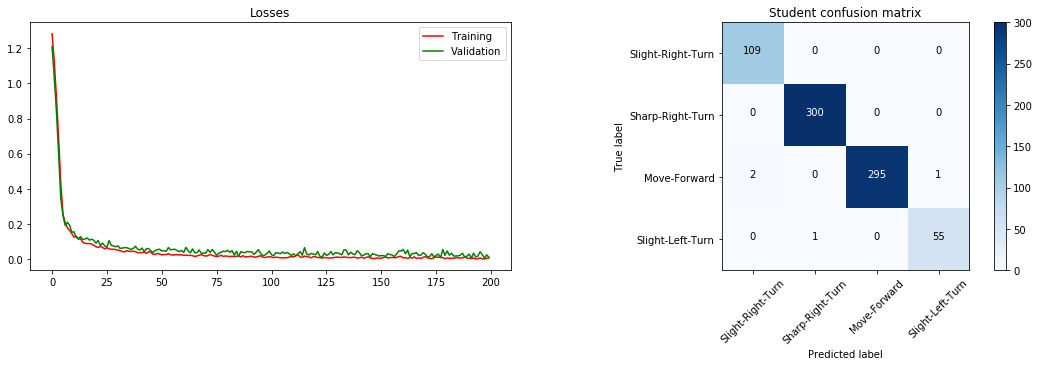


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.007017038007863697
0.02870948661514222
nan
[ 14  61 141 143 214 218 259 287 459 476 538 658 734]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

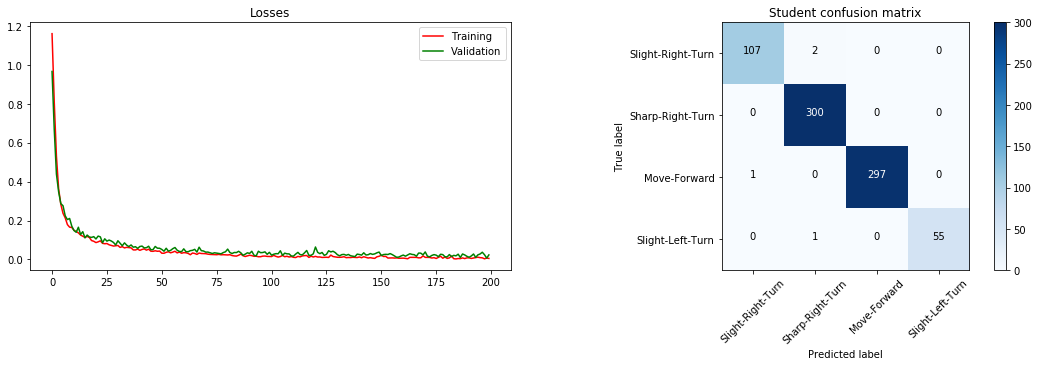


 ( Micro Averaging ) Accuracy: 98.6893840105

 ( Macro Averaging ) Accuracy: 98.8204456094
0.007140235910878113
0.028815258221107573
nan
[143]
Confusion matrix, without normalization
[[103   0   6   0]
 [  0 298   2   0]
 [  0   0 297   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

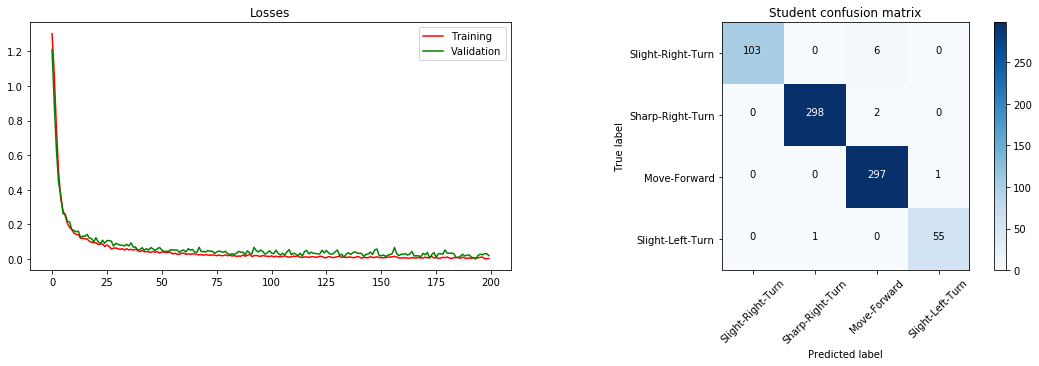


 ( Micro Averaging ) Accuracy: 98.6893840105

 ( Macro Averaging ) Accuracy: 98.6893840105
0.005551769331585846
0.02487996052633263
nan
[143 214 287]
Confusion matrix, without normalization
[[104   2   3   0]
 [  0 300   0   0]
 [  1   3 294   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

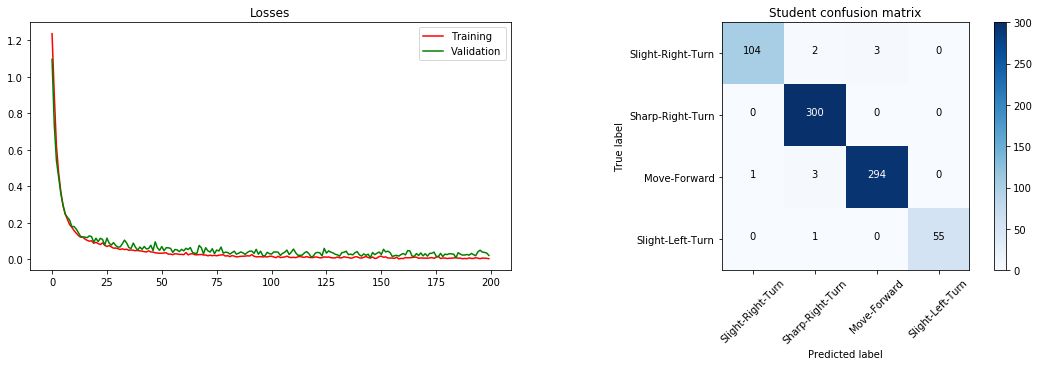


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.006757536041939711
0.03314100492984877
nan
[143 214 287]
Confusion matrix, without normalization
[[107   0   2   0]
 [  0 299   1   0]
 [  1   0 297   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

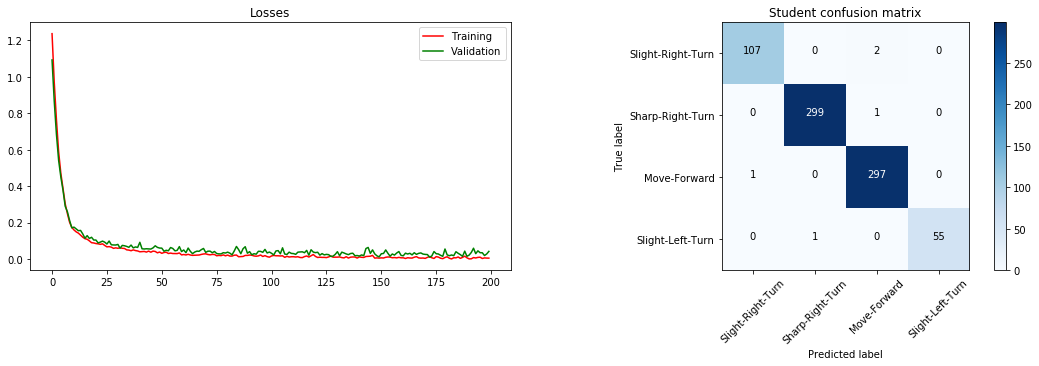


 ( Micro Averaging ) Accuracy: 98.5583224115

 ( Macro Averaging ) Accuracy: 98.4272608126
0.006018348623853212
0.027522690799258172
nan
[143 214 287]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  5   3 290   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

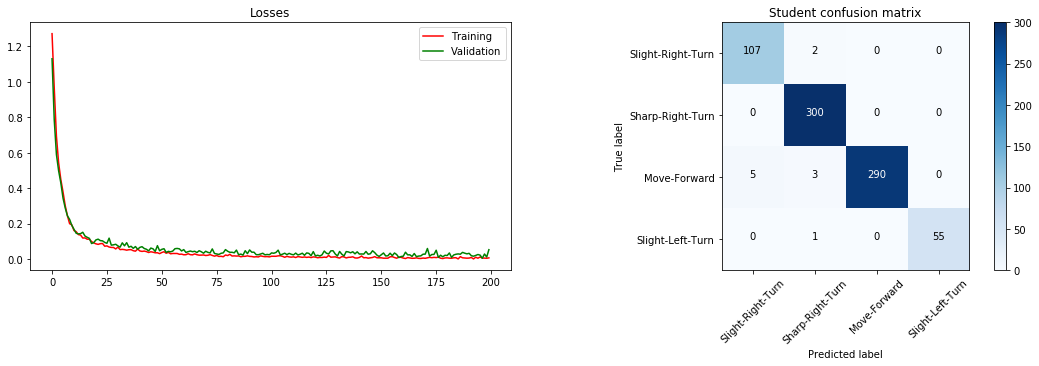

Epoch - Mean accuracy - Accuracy standard deviation - Dropout probabilities per layer   -   Mean Variation ratio  -  Mean Predictive Entropy  -  Mean Mutual Information
200 - 99.21363040629096     0.03986082916315997      [0.05180799 0.05748577 0.03127628]  -  0.0058005679335954565  -  0.028081083568541332  -  nan


In [10]:
results = []

# get results for multiple N
#for N, nb_epoch in zip(Ns, nb_epochs):
for nb_epoch in nb_epochs:
       
    # repeat exp multiple times
    rep_results = []
    for i in xrange(nb_reps):
        X_train, Y_train = X_tr, Y_tr
        X_val, Y_val = X_v, Y_v
        hist, model, ELBO = fit_model(nb_epoch, X_train, Y_train, validation_data=(X_val, Y_val))
        valid_loss_hist = hist.history['val_loss']
        train_loss_hist = hist.history['loss']
       
    
        MC_samples = np.array([model.predict(X_val) for _ in range(K_test)])
        acc, acc_maj_vote, MC_means, MC_pred, mode_fx = test(Y_val, MC_samples)  
        
              
        #Average variation ratio over the minibatch
        variation_ratio = np.zeros(MC_pred.shape)
        for j in xrange(len(MC_pred)):
            variation_ratio[j] = 1 - ((mode_fx[j])[1])/float(K_test)
        variation_ratio_avg_VR = np.sum(variation_ratio)/float(len(MC_pred))
        print(variation_ratio_avg_VR)
       
        #Average predictive entropy over minibatch
        predictive_entropy = -1*np.sum(MC_means*np.log(MC_means),axis=-1)
        predictive_entropy_avg_H = np.sum(predictive_entropy)/float(len(MC_pred))
        print(predictive_entropy_avg_H)
        
        #Average mutual information over minibatch
        expected_entropy = np.sum(np.sum(MC_samples*np.log(MC_samples),axis=-1),axis=0)/float(K_test)
        mutual_information_avg_MI = predictive_entropy_avg_H + np.sum(expected_entropy)/float(len(MC_pred))
        print(mutual_information_avg_MI)
        
              
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
              
        """
        Save best model weights
        """
        if not np.argwhere(np.isnan(predictive_entropy)).size:
            id = np.argwhere(np.isnan(expected_entropy))
            print(id.flatten())
            if not id.size:
                expected_entropy[id.flatten()] = 1.0
                mutual_information_avg_MI = predictive_entropy_avg_H + np.sum(expected_entropy)/float(len(MC_pred))
            if rep_results!=[]:
                if acc>rep_results[-1][0]:
                   model.save_weights('/home/yannis/Desktop/compress_bnn/DNN_model2/DNN_weights.h5') 
            else:
                model.save_weights('/home/yannis/Desktop/compress_bnn/DNN_model2/DNN_weights.h5')

            rep_results += [(acc, acc_maj_vote, ps, variation_ratio_avg_VR, predictive_entropy_avg_H, mutual_information_avg_MI )]
            plot(range(nb_epoch),train_loss=train_loss_hist,valid_loss=valid_loss_hist,valid_y=Y_val,preds=MC_pred)
    
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[2] for r in rep_results], 0)
    VR_avg = np.mean([r[3] for r in rep_results])
    H_avg = np.mean([r[4] for r in rep_results])
    MI_avg = np.mean([r[5] for r in rep_results])
    print("Epoch - Mean accuracy - Accuracy standard deviation - Dropout probabilities per layer   -   Mean Variation ratio  -  Mean Predictive Entropy  -  Mean Mutual Information")
    print nb_epoch, '-', test_mean, '   ', test_std_err, '    ',ps, ' - ', VR_avg, ' - ', H_avg, ' - ',MI_avg
    sys.stdout.flush()
    results += [rep_results]
    



In [ ]:
"""
#KeplerMapper
from kmapper import jupyter
import kmapper as km
from sklearn import metrics, cluster, preprocessing

predict_penultimate_layer =  K.function([model.layers[0].input, K.learning_phase()], [model.layers[-2].output])
X_inverse_test = np.array(predict_penultimate_layer([X_v, 1]))[0]
print((X_inverse_test.shape, "X_inverse_valid shape"))

X_projected_test = np.c_[np.argmax(Y_v,axis=-1),variation_ratio, predictive_entropy, predictive_entropy+expected_entropy]
print((X_projected_test.shape, "X_projected_valid shape"))

mapper = km.KeplerMapper(verbose=0)
G = mapper.map(X_projected_test,
               X_inverse_test, 
               clusterer=cluster.AgglomerativeClustering(n_clusters=2),
               overlap_perc=0.9,
               nr_cubes=10)

color_function_output = predictive_entropy+expected_entropy

_ = mapper.visualize(G,
                 projected_X=X_projected_test,
                 projected_X_names=["Variation Ratio", "Predictive Entropy", "Mutual Information"],
                 color_function=color_function_output,
                 title="Confidence Graph for an MLP trained on Obstacle Avoidance dataset")

jupyter.display("mapper_visualization_output.html")
"""

In [ ]:
import pickle
with open('./concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# import pickle
# with open('concrete-dropout.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_epistemic_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
print best_tests.mean(0)
print best_ps.mean(1)

In [ ]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(N, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(N, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

In [ ]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(N, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()